In [132]:
import glob
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.patches import Patch


def order_keys(fp): 
    dat_fps = glob.glob(fp)
    keys = set(fp.split('/')[-1].split('_')[0] for fp in dat_fps)
    
    lengths = []
    for key in keys:
        bed_fp, surf_fp = sorted(fp for fp in dat_fps if key in fp)

        surf = np.loadtxt(surf_fp)
        bed  = np.loadtxt(bed_fp )

        x   = surf[:,0]
        z_s = surf[:,1]
        z_b =  bed[:,1]

        mask = z_s <= z_b
        term = np.where(np.diff(mask.astype(np.int))!=0)[0][0]
        L    = (x[-1]-x[term])/1e3
        
        lengths.append(L)
        
    return [list(keys)[i] for i in np.argsort(lengths)]

In [134]:
# find all the input .dat files and strip the key-id from the file path, 
# only want unique values, sort based on glacier length 
keys = order_keys("../input_data/*.dat")

# legend labels dictionary
labels = {'glc1'    : ['South' , 0],
          'crmpt12'   : ['Glacier 12', 1],
          'crmpt18' : ['Glacier 18', 2],
          'lilk'    : ['Little Kluane', 3],
          'klun'    : ['Kluane', 4],
          'sprg'      : ['Spring', 5], 
          'klut'    : ['Klutlan', 6], 
          'twds'    : ['Tweedsmuir', 8],
          'fish'      : ['Fisher', 7]}

# hex codes from colorbrewer
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99',
          '#386cb0','#f0027f','#bf5b17','#666666', '#7fc97f']

color = plt.cm.tab20b(np.linspace(0, 1,9), 9)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for color in colors: 
    color[3] = 0.5

Text(0.5, 0, 'Distance along flowline [km]')

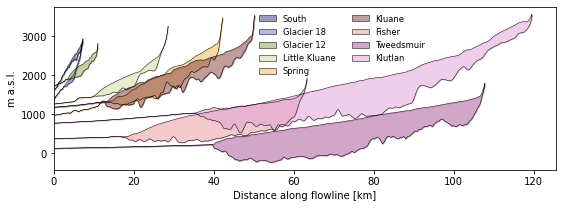

In [135]:
fig, ax = plt.subplots(figsize=(9,3))

i = 0 

legend_elements = [ ]


for key in keys:
    # skip the secondary flowlines for now
    if '-a' in key: continue

    surf_fp = '../input_data/{}_surf.dat'.format(key)
    bed_fp  = '../input_data/{}_bed.dat' .format(key)
    
    surf = np.loadtxt(surf_fp)
    bed  = np.loadtxt(bed_fp )
    
    x   = surf[:,0]
    z_s = surf[:,1]
    z_b =  bed[:,1]
    
    
    ax.plot(x/1e3, z_s, c='k', lw=0.5)
    ax.plot(x/1e3, z_b, c='k', lw=0.5)
    ax.fill_between(x/1e3, z_b, z_s, color=colors[i])
    
    legend_elements.append( Patch(facecolor=colors[i], edgecolor='k',
                                  linewidth = 0.5, 
                                  label=labels[key.split('-')[0]][0]))
    
    i += 1

# Place legend in the correct spot
ax.legend(handles = legend_elements, fontsize='small', ncol=2, 
          loc = 'upper center', framealpha=0.00, frameon=False, 
          bbox_to_anchor=(0.575, 1)
          )

ax.set_xlim(0, None)
ax.set_ylabel('m a.s.l.')
ax.set_xlabel('Distance along flowline [km]')

#fig.savefig('/Users/andrewnolan/Desktop/all_glaciers.png', dpi=400, bbox_inches='tight', facecolor='w')

In [136]:
lenghts = [ ]

i = 0 
for key in keys:
    # skip the secondary flowlines for now
    #if '-a' in key: continue

    surf_fp = '../input_data/{}_surf.dat'.format(key)
    bed_fp  = '../input_data/{}_bed.dat' .format(key)
    
    surf = np.loadtxt(surf_fp)
    bed  = np.loadtxt(bed_fp )
    
    x   = surf[:,0]
    z_s = surf[:,1]
    z_b =  bed[:,1]
        
    mask = z_s <= z_b
    term = np.where(np.diff(mask.astype(np.int))!=0)[0][0]
    
    H = np.ma.MaskedArray(z_s - z_b, mask=mask)
    L = (x[-1]-x[term])/1e3
    R = z_s[~mask].max() - z_s[~mask].min()
    α = np.gradient(z_s[~mask], 10).mean()*100
    β = np.gradient(z_b[~mask], 10).mean()*100
    
    dxs = [50, 100, 200, 250]
    Nxs = []
    for dx in dxs: 
        Nxs.append(int((x[-1]-x[0])/dx))
        
    string = ("| {:<12} | {:<15} | {:>6.2f} |"
              " {:>8.2f} | {:>6.0f} | {:>9f}"
              " | ".format("`{}`".format(key), 
                           labels[key.split('-')[0]][0], 
                           H.mean(), L, R, α, β))
    string += ''.join(["{:>12} |".format(i) for i in Nxs])
    if i == 0: 
        print("|:{:<12}:|:{:<15}:|:{:<6}:|"
              ":{:<8}:|:{:>6}:|:{:>9}:| "
              .format('Key', "Glacier", "H (m) ", "L (km)", "R (m) ", "α (deg) ", β)+
             ''.join([" Nx @ dx={:<3} |".format(i) for i in dxs])) 
        print("|"+14*"-"+"|"+17*"-"+"|"+8*"-"+"|"+10*"-"+"|"+8*"-"+"|"+11*"-"+"|"+
              "-"*14+"|"+''.join(["-"*13+"|".format(i) for i in Nxs[1:]]))
    print(string)
    i+=1

|:Key         :|:Glacier        :|:H (m) :|:L (km)  :|:R (m) :|: α (deg) :|  Nx @ dx=50  | Nx @ dx=100 | Nx @ dx=200 | Nx @ dx=250 |
|--------------|-----------------|--------|----------|--------|-----------|--------------|-------------|-------------|-------------|
| `glc1-b`     | South           |  81.30 |     4.64 |    797 | 17.825805 |          145 |          72 |          36 |          29 |
| `crmpt18-b`  | Glacier 18      |  71.61 |     4.82 |   1158 | 24.113005 |          146 |          73 |          36 |          29 |
| `glc1-a`     | South           | 106.18 |     4.97 |    907 | 18.418451 |          145 |          72 |          36 |          29 |
| `crmpt18-a`  | Glacier 18      |  98.15 |     6.17 |   1215 | 19.726604 |          173 |          86 |          43 |          34 |
| `crmpt12`    | Glacier 12      | 182.22 |     7.43 |    902 | 12.307036 |          220 |         110 |          55 |          44 |
| `lilk-b`     | Little Kluane   | 214.32 |    18.44 |   1145 |  6.81

In [126]:
keys

[]